https://vk.com/@meaning_data-pandas-in-jupiter-notebook
    Как оформлять таблицы в Jupyter Notebook?

# Курсовой проект "Real Estate Price Prediction"

Сдача проекта:
1. Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту")
**ссылку на файл Jupyter Notebook**. (Pull request не нужен).
2. Приложить файл с названием по образцу **YourName_predictions.csv**
с предсказанными ценами для квартир из test.csv (файл должен содержать два поля: Id, Price).
В файле с предсказаниями должна быть 5001 строка (шапка + 5000 предсказаний). 

Сроки и условия сдачи:

1. Сдать проект нужно в течение **72 часов** после начала Урока 10 ("Вебинар. Консультация по итоговому проекту").
2. Для успешной сдачи должны быть все предсказания (для 5000 квартир) и R2 (sklearn.metrics.r2_score) должен быть **больше 0.65**.
3. При сдаче до дедлайна результат проекта может попасть в топ лучших результатов.
Повторная сдача и проверка результатов возможны только при условии предыдущей неуспешной сдачи.
Успешный проект нельзя пересдать в целях повышения результата. В качестве итогового результата берется первый успешный результат, последующие успешные результаты не учитываются.
4. Проекты, сданные после дедлайна или сданные повторно, не попадают в топ лучших результатов, но можно узнать результат.

Рекомендации для файла с кодом (ipynb):
1. Файл должен содержать заголовки и комментарии
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. Хорошо добавлять графики, поясняющие принятые решения (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. При использовании статистик (среднее, медиана и т.д.) в качестве признаков,
считать их на трейне и использовать на контрольных и тестовых данных. 
8. Оценку качества модели можно выполнять на отложенной выборки или использовать кросс-валидацию. Также рекомендуется самостоятельно проверять точность предсказания на https://www.kaggle.com/c/realestatepriceprediction.
9. Проект должен полностью отрабатывать за разумное время (не больше 10 минут),
поэтому в финальный вариант лучше не включать GridSearchCV с перебором 
параметров, а сразу использовать подобранные параметры.
10. Допускается применение библиотек Python и моделей машинного обучения,
которые были в курсе Библиотеки Python для Data Science. 

## Подключение библиотек и скриптов

In [113]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')
sns.set_context("paper", font_scale=1.5)  
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 50)

**Пути к директориям и файлам**

In [7]:
TRAIN_DATASET_PATH = './train.csv'
TEST_DATASET_PATH = './test.csv'
PREPARED_DATASET_PATH = './train_prepared.csv'

## Загрузка данных

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [6]:
train_df = pd.read_csv(TRAIN_DATASET_PATH, index_col='Id')
train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14038,35,2.00,47.98,29.44,6.00,7,9.00,1969,0.09,B,B,33,7976,5,nan,0,11,B,"184,966.93"
15053,41,3.00,65.68,40.05,8.00,7,9.00,1978,0.00,B,B,46,10309,1,240.00,1,16,B,"300,009.45"
4765,53,2.00,44.95,29.20,0.00,8,12.00,1968,0.05,B,B,34,7759,0,229.00,1,3,B,"220,925.91"
5809,58,2.00,53.35,52.73,9.00,8,17.00,1977,0.44,B,B,23,5735,3,"1,084.00",0,5,B,"175,616.23"
10783,99,1.00,39.65,23.78,7.00,11,12.00,1976,0.01,B,B,35,5776,1,"2,078.00",2,4,B,"150,226.53"


In [8]:
test_df = pd.read_csv(TEST_DATASET_PATH, index_col='Id')
test_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
725,58,2.00,49.88,33.43,6.00,6,14.00,1972,0.31,B,B,11,2748,1,nan,0,0,B
15856,74,2.00,69.26,nan,1.00,6,1.00,1977,0.08,B,B,6,1437,3,nan,0,2,B
5480,190,1.00,13.60,15.95,12.00,2,5.00,1909,0.00,B,B,30,7538,87,"4,702.00",5,5,B
15664,47,2.00,73.05,51.94,9.00,22,22.00,2007,0.10,B,B,23,4583,3,nan,3,3,B
14275,27,1.00,47.53,43.39,1.00,17,17.00,2017,0.07,B,B,2,629,1,nan,0,0,A


In [9]:
train_df.shape, test_df.shape

((10000, 19), (5000, 18))

## Приведение типов

In [10]:
train_df.dtypes

DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [11]:
train_df['DistrictId'] = train_df['DistrictId'].astype(str)
test_df['DistrictId'] = test_df['DistrictId'].astype(str)

## Обзор данных

### Целевая переменная

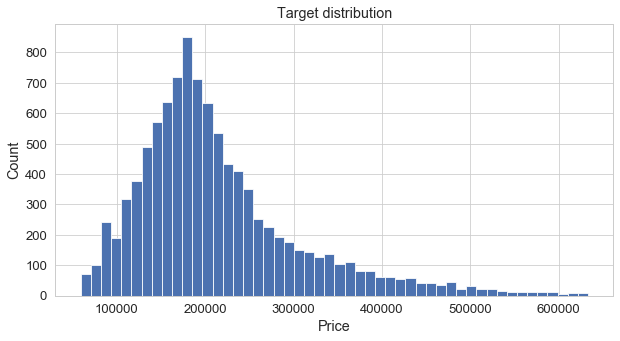

In [12]:
plt.figure(figsize = (10, 5))

train_df['Price'].hist(bins=50)
plt.ylabel('Count')
plt.xlabel('Price')
plt.title('Target distribution');

### Количественные переменные

In [13]:
train_df.nunique()

DistrictId         205
Rooms                9
Square           10000
LifeSquare        7887
KitchenSquare       58
Floor               33
HouseFloor          44
HouseYear           97
Ecology_1          129
Ecology_2            2
Ecology_3            2
Social_1            51
Social_2           142
Social_3            30
Healthcare_1        79
Helthcare_2          7
Shops_1             16
Shops_2              2
Price            10000
dtype: int64

In [14]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,"10,000.00","10,000.00","7,887.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","5,202.00","10,000.00","10,000.00","10,000.00"
mean,1.89,56.32,37.20,6.27,8.53,12.61,"3,990.17",0.12,24.69,"5,352.16",8.04,"1,142.90",1.32,4.23,"214,138.86"
std,0.84,21.06,86.24,28.56,5.24,6.78,"200,500.26",0.12,17.53,"4,006.80",23.83,"1,021.52",1.49,4.81,"92,872.29"
min,0.00,1.14,0.37,0.00,1.00,0.00,"1,910.00",0.00,0.00,168.00,0.00,0.00,0.00,0.00,"59,174.78"
25%,1.00,41.77,22.77,1.00,4.00,9.00,"1,974.00",0.02,6.00,"1,564.00",0.00,350.00,0.00,1.00,"153,872.63"
50%,2.00,52.51,32.78,6.00,7.00,13.00,"1,977.00",0.08,25.00,"5,285.00",2.00,900.00,1.00,3.00,"192,269.64"
75%,2.00,65.90,45.13,9.00,12.00,17.00,"2,001.00",0.20,36.00,"7,227.00",5.00,"1,548.00",2.00,6.00,"249,135.46"
max,19.00,641.07,"7,480.59","2,014.00",42.00,117.00,"20,052,011.00",0.52,74.00,"19,083.00",141.00,"4,849.00",6.00,23.00,"633,233.47"


In [15]:
feature_num_names = train_df.drop('Price', axis=1).select_dtypes(include=['float64', 'int64']).\
        columns.tolist()
feature_num_names

['Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1']

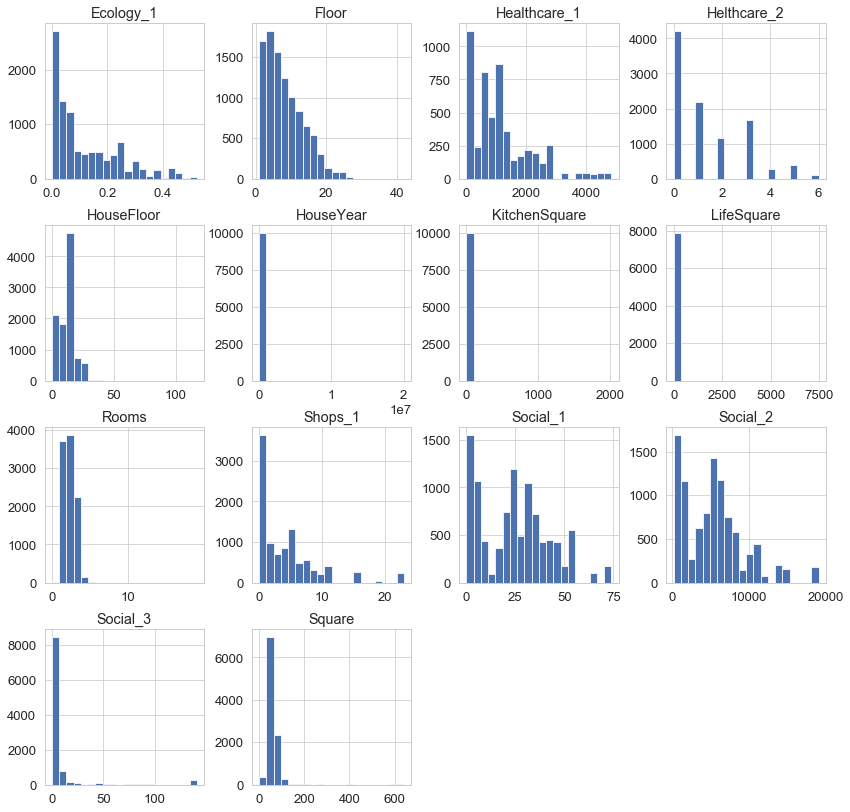

In [16]:
train_df[feature_num_names].hist(figsize=(14,14), bins=20, grid=True);

### Категориальные переменные

**Ecology_2, Ecology_3, Shops_2**

In [17]:
feature_cat_names = train_df.select_dtypes(include='object').columns.tolist()
feature_cat_names

['DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [18]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

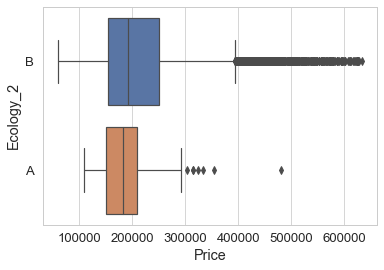

In [19]:
sns.boxplot('Price', 'Ecology_2', data=train_df);

In [20]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

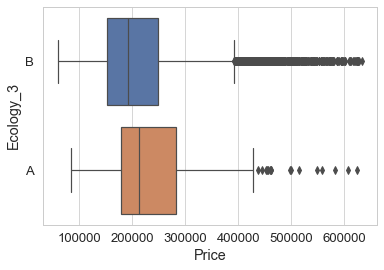

In [21]:
sns.boxplot('Price', 'Ecology_3', data=train_df);

In [22]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

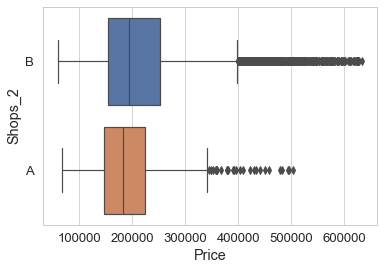

In [23]:
sns.boxplot('Price', 'Shops_2', data=train_df);

In [24]:
feature_bin_names = ['Ecology_2', 'Ecology_3', 'Shops_2']

train_df[feature_bin_names] = train_df[feature_bin_names].replace({'A':0, 'B':1})
test_df[feature_bin_names] = test_df[feature_bin_names].replace({'A':0, 'B':1})

train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 19 columns):
DistrictId       10000 non-null object
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null int64
Ecology_3        10000 non-null int64
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null int64
Price            10000 non-null float64
dtypes: float64(8), int64(10), object(1)
memory usage: 1.8+ MB


**Helthcare_2**

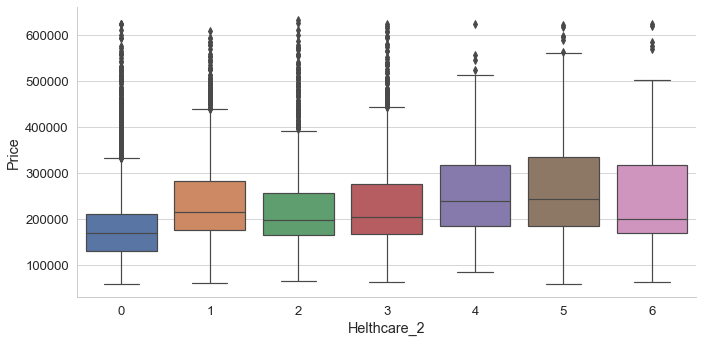

In [25]:
sns.catplot('Helthcare_2', 'Price', kind="box", data=train_df, aspect=2/1);

## Обработка пропусков

In [26]:
train_df.isna().sum()[train_df.isna().sum() != 0]

LifeSquare      2113
Healthcare_1    4798
dtype: int64

**LifeSquare**

In [27]:
train_df.loc[train_df['LifeSquare'].isna(), 'LifeSquare'] = \
    train_df['Square'] - train_df['KitchenSquare']
test_df.loc[test_df['LifeSquare'].isna(), 'LifeSquare'] = \
    test_df['Square'] - test_df['KitchenSquare']

**Healthcare_1**

In [28]:
train_df['Healthcare_1'].fillna(train_df['Healthcare_1'].median(), inplace=True)
test_df['Healthcare_1'].fillna(train_df['Healthcare_1'].median(), inplace=True)

## Обработка выбросов

**Rooms**

In [29]:
train_df['Rooms'].value_counts()

2.00     3880
1.00     3705
3.00     2235
4.00      150
5.00       18
0.00        8
10.00       2
19.00       1
6.00        1
Name: Rooms, dtype: int64

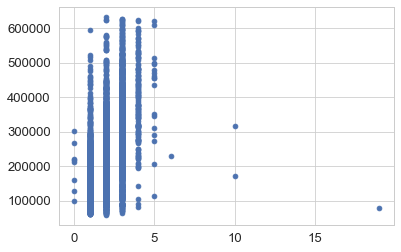

In [30]:
plt.scatter(train_df['Rooms'], train_df['Price']);

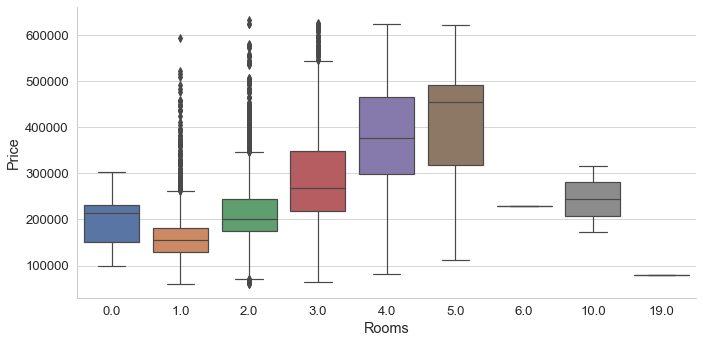

In [31]:
sns.catplot('Rooms', 'Price', kind="box", data=train_df, aspect=2/1);

In [32]:
test_df['Rooms'].value_counts()

2.00     2030
1.00     1769
3.00     1099
4.00       90
5.00        7
0.00        2
6.00        2
17.00       1
Name: Rooms, dtype: int64

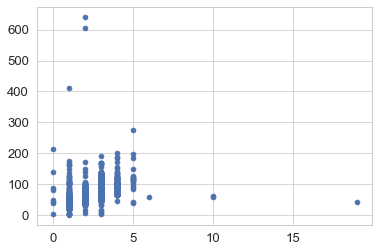

In [33]:
plt.scatter(train_df['Rooms'], train_df['Square']);

In [34]:
train_df['Rooms'].mode()[0]

2.0

In [35]:
train_df.loc[(train_df['Rooms'] > 5)|(train_df['Rooms'] == 0), 'Rooms'] = train_df['Rooms'].mode()[0]
test_df.loc[(test_df['Rooms'] > 5)|(test_df['Rooms'] == 0), 'Rooms'] = train_df['Rooms'].mode()[0] # !!

**Square, LifeSquare, KitchenSquare**

In [36]:
train_df[['Square', 'LifeSquare', 'KitchenSquare']].describe()

,Square,LifeSquare,KitchenSquare
count,"10,000.00","10,000.00","10,000.00"
mean,56.32,41.80,6.27
std,21.06,77.82,28.56
min,1.14,0.37,0.00
25%,41.77,25.49,1.00
50%,52.51,37.04,6.00
75%,65.90,49.82,9.00
max,641.07,"7,480.59","2,014.00"


In [37]:
train_df['KitchenSquare'].value_counts()

1.00        2460
8.00        1306
5.00        1169
10.00       1075
6.00        1038
9.00         843
0.00         697
7.00         609
12.00        249
11.00        233
13.00         67
14.00         51
4.00          39
15.00         31
3.00          22
16.00         16
20.00         14
17.00         12
19.00         11
18.00          6
2.00           4
22.00          3
41.00          2
112.00         2
25.00          2
            ... 
66.00          1
48.00          1
40.00          1
2,014.00       1
35.00          1
60.00          1
78.00          1
27.00          1
84.00          1
62.00          1
42.00          1
63.00          1
39.00          1
1,970.00       1
36.00          1
75.00          1
26.00          1
21.00          1
29.00          1
23.00          1
73.00          1
123.00         1
31.00          1
53.00          1
54.00          1
Name: KitchenSquare, Length: 58, dtype: int64

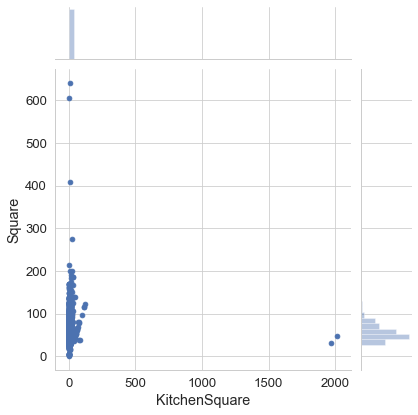

In [38]:
sns.jointplot(train_df['KitchenSquare'], train_df['Square'], kind='scatter', height=6);

In [39]:
train_df.loc[(train_df['KitchenSquare'] > 150) | \
             (train_df['KitchenSquare'] > train_df['Square']), :]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14656,62,1.00,47.10,46.45,"2,014.00",4,1.00,2014,0.07,1,1,2,629,1,900.00,0,0,0,"108,337.48"
13703,42,1.00,38.07,19.72,73.00,9,10.00,2006,0.16,1,1,21,5731,0,900.00,1,0,1,"160,488.03"
6569,27,1.00,38.22,18.72,84.00,4,17.00,2018,0.01,1,1,4,915,0,900.00,0,0,1,"99,079.96"
14679,81,1.00,32.28,19.28,"1,970.00",6,1.00,1977,0.01,1,1,30,5285,0,645.00,6,6,1,"105,539.56"


In [40]:
train_df.loc[(train_df['KitchenSquare'] > 150) | \
             (train_df['KitchenSquare'] > train_df['Square']),
             'KitchenSquare'] = train_df['KitchenSquare'].median()

test_df.loc[(test_df['KitchenSquare'] > 150) | \
            (test_df['KitchenSquare'] > test_df['Square']),
            'KitchenSquare'] = train_df['KitchenSquare'].median()

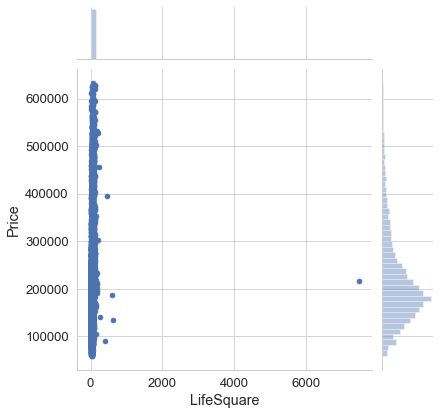

In [41]:
sns.jointplot(train_df['LifeSquare'], train_df['Price'], kind='scatter', height=6);

In [42]:
train_df.loc[(train_df['LifeSquare'] > 400), 'LifeSquare'] = \
        train_df['LifeSquare'].median()
test_df.loc[(test_df['LifeSquare'] > 400), 'LifeSquare'] = \
        train_df['LifeSquare'].median()

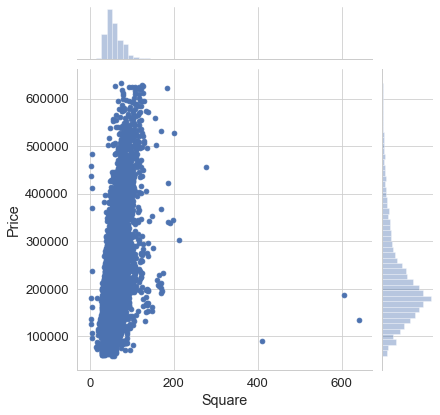

In [43]:
sns.jointplot(train_df['Square'], train_df['Price'], kind='scatter', height=6);

In [44]:
train_df.loc[(train_df['Square'] > 400) | (train_df['Square'] < 10), :]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
1748,88,2.00,5.50,67.63,1.00,24,22.00,1977,0.13,1,1,43,8429,3,900.00,3,9,1,"412,511.09"
11526,27,1.00,4.63,1.97,1.00,18,1.00,1977,0.01,1,1,4,915,0,900.00,0,0,1,"107,604.27"
10202,6,1.00,2.60,4.60,1.00,3,25.00,2014,0.24,1,1,5,1564,0,540.00,0,0,1,"137,597.60"
10527,27,1.00,4.38,40.81,1.00,10,17.00,2013,0.21,1,1,9,1892,0,900.00,0,1,1,"97,560.72"
9487,5,1.00,5.13,5.55,1.00,1,1.00,1977,0.15,1,1,16,3433,4,"2,643.00",4,5,1,"369,472.40"
28,9,2.00,604.71,37.04,1.00,17,18.00,1977,0.16,1,1,25,5648,1,30.00,2,4,1,"187,717.24"
2307,102,1.00,409.43,37.04,10.00,4,4.00,2016,0.24,1,1,26,3889,6,705.00,3,6,1,"90,470.43"
3224,27,2.00,2.38,0.87,0.00,1,0.00,1977,0.02,1,1,2,469,0,900.00,0,0,1,"126,596.94"
4504,27,3.00,4.39,5.61,1.00,8,19.00,2016,0.21,1,1,9,1892,0,900.00,0,1,1,"161,379.07"


In [45]:
train_df.loc[(train_df['Square'] > 400) | (train_df['Square'] < 10), 'Square'] = \
            train_df['Square'].median()

test_df.loc[(test_df['Square'] > 400) | (test_df['Square'] < 10), 'Square'] = \
            train_df['Square'].median()

In [46]:
len(train_df[(train_df['Square'] < train_df['LifeSquare'] + train_df['KitchenSquare'])])

830

In [47]:
train_df[(train_df['Square'] < train_df['LifeSquare'] + train_df['KitchenSquare'])].head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
5809,58,2.00,53.35,52.73,9.00,8,17.00,1977,0.44,1,1,23,5735,3,"1,084.00",0,5,1,"175,616.23"
8054,23,1.00,42.53,43.97,1.00,3,9.00,2014,0.03,1,1,0,168,0,900.00,0,0,1,"95,338.20"
10521,38,3.00,104.21,106.34,0.00,20,0.00,2017,0.06,1,1,15,2787,2,520.00,0,7,1,"435,462.05"
7596,23,1.00,47.08,46.81,12.00,3,9.00,1977,0.01,1,1,2,475,0,900.00,0,0,1,"96,029.17"
2301,1,2.00,61.40,65.22,0.00,17,22.00,2016,0.01,1,1,1,264,0,900.00,0,1,1,"199,215.45"


In [48]:
train_df[['Square', 'LifeSquare', 'KitchenSquare']].describe()

,Square,LifeSquare,KitchenSquare
count,"10,000.00","10,000.00","10,000.00"
mean,56.22,40.86,5.86
std,19.06,20.57,5.07
min,13.78,0.37,0.00
25%,41.79,25.49,1.00
50%,52.51,37.04,6.00
75%,65.89,49.77,9.00
max,275.65,263.54,123.00


In [49]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Scatter3d(
    x=train_df['Square'],
    y=train_df['LifeSquare'],
    z=train_df['KitchenSquare'], 
    mode='markers',
    marker=dict(
        size=5,
        color=train_df['Price'], 
        colorscale='jet',  
        colorbar=dict(thickness=10),
        line=dict(width=2, color='DarkSlateGrey')
    )
)])

fig.update_layout(
    margin=dict(l=0, r=0, b=0, t=0),
    scene=dict(
        xaxis_title='Square',
        yaxis_title='LifeSquare',
        zaxis_title='KitchenSquare'),
    )

fig.show()

ModuleNotFoundError: No module named 'plotly'

**HouseFloor, Floor**

In [50]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [51]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42])

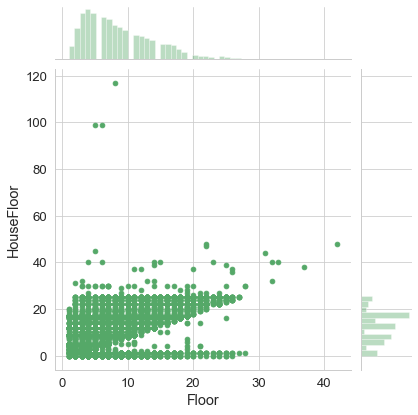

In [52]:
sns.jointplot(train_df['Floor'], train_df['HouseFloor'], kind='scatter', height=6, color='g');

In [53]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].mode()[0]
test_df.loc[test_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].mode()[0]

In [54]:
train_df.loc[train_df['HouseFloor'] > 98, 'HouseFloor'] = train_df['HouseFloor'].mode()[0]
test_df.loc[test_df['HouseFloor'] > 98, 'HouseFloor'] = train_df['HouseFloor'].mode()[0]

In [55]:
floor_outliers_train = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
floor_outliers_test = test_df.loc[test_df['Floor'] > test_df['HouseFloor']].index

floor_outliers_train

Int64Index([10953,  2119, 11935,  6486, 10521, 10103,  8443,  1063, 14675,
            14020,
            ...
            10361,  4660, 16050, 12590,  5071,  2237, 16159,  4145, 11553,
               77],
           dtype='int64', name='Id', length=1578)

In [56]:
train_df.loc[floor_outliers_train, 'Floor'] = \
    train_df.loc[floor_outliers_train, 'HouseFloor'].apply(lambda x: random.randint(1, x))
test_df.loc[floor_outliers_test, 'Floor'] = \
    test_df.loc[floor_outliers_test, 'HouseFloor'].apply(lambda x: random.randint(1, x))

**HouseYear**

In [57]:
train_df['HouseYear'].sort_values(ascending=False)

Id
10814    20052011
11607        4968
6731         2020
8892         2020
14318        2020
9600         2020
2731         2020
8433         2020
9303         2020
3445         2020
7026         2020
2530         2020
8832         2020
6915         2020
13914        2020
6845         2020
4345         2020
14664        2020
15051        2020
12191        2020
3511         2020
13098        2019
12342        2019
2512         2019
11714        2019
           ...   
7018         1931
6700         1931
4352         1931
8921         1930
15902        1930
3128         1930
4212         1929
9642         1929
15391        1928
12329        1919
462          1919
5078         1919
15375        1918
12381        1918
14543        1918
10919        1918
12229        1918
13872        1917
15193        1917
10439        1917
7920         1916
6751         1914
2085         1912
14556        1912
13288        1910
Name: HouseYear, Length: 10000, dtype: int64

In [58]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020

## Обработка редких категорий

**DistrictId**

In [59]:
print(train_df['DistrictId'].nunique(), ' уникальных  значений в train')
print(test_df['DistrictId'].nunique(), ' уникальных  значений в test')

205  уникальных  значений в train
201  уникальных  значений в test


In [60]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
                .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294
5,62,247
6,30,228
7,58,179
8,53,174
9,21,165


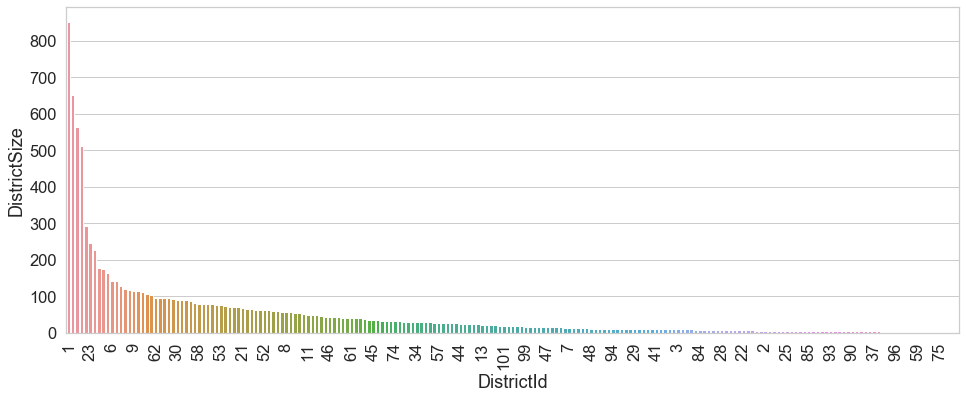

In [61]:
sns.set(style="whitegrid", font_scale=1.5)
f, ax = plt.subplots(figsize=(16, 6))
sns.barplot(y='DistrictSize', x='DistrictId', 
            data=district_size,
            order=district_size.sort_values(by='DistrictSize', ascending=False)['DistrictId']
           );
ax.tick_params(axis='x', rotation=90)
ax.xaxis.set_major_locator(plt.MaxNLocator(50))

In [62]:
district_size.loc[district_size['DistrictSize'] > 100, :]

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294
5,62,247
6,30,228
7,58,179
8,53,174
9,21,165


In [63]:
districts_popular = district_size.loc[district_size['DistrictSize'] > 100, 'DistrictId'].tolist()

In [68]:
train_df.loc[~train_df['DistrictId'].isin(districts_popular), 'DistrictId'] = 999
test_df.loc[~test_df['DistrictId'].isin(districts_popular), 'DistrictId'] = 999

In [69]:
test_df['DistrictId'].value_counts()

999    2551
27      391
1       344
23      264
6       257
9       132
62      122
30      115
58       91
53       91
21       70
52       67
8        64
61       64
46       61
74       61
34       61
57       54
45       49
44       46
11       45
Name: DistrictId, dtype: int64

## Построение новых признаков

**DistrictSize**

In [70]:
train_df = train_df.merge(district_size, on='DistrictId', how='left').set_index(train_df.index)
test_df = test_df.merge(district_size, on='DistrictId', how='left').set_index(test_df.index)
train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,DistrictSize
Id,,,,,,,,,,,,,,,,,,,,
14038,999,2.00,47.98,29.44,6.00,7,9.00,1969,0.09,1,1,33,7976,5,900.00,0,11,1,"184,966.93",15
15053,999,3.00,65.68,40.05,8.00,7,9.00,1978,0.00,1,1,46,10309,1,240.00,1,16,1,"300,009.45",15
4765,53,2.00,44.95,29.20,0.00,8,12.00,1968,0.05,1,1,34,7759,0,229.00,1,3,1,"220,925.91",174
5809,58,2.00,53.35,52.73,9.00,8,17.00,1977,0.44,1,1,23,5735,3,"1,084.00",0,5,1,"175,616.23",179
10783,999,1.00,39.65,23.78,7.00,11,12.00,1976,0.01,1,1,35,5776,1,"2,078.00",2,4,1,"150,226.53",15


**PriceOneSMeter**

In [71]:
train_df['PriceOneSMeter'] = train_df['Price'] / train_df['Square']

In [72]:
train_df['PriceOneSMeter'].describe()

count   10,000.00
mean     3,892.16
std      1,251.63
min        752.59
25%      2,917.33
50%      3,908.65
75%      4,690.65
max     11,854.65
Name: PriceOneSMeter, dtype: float64

**PriceOneSMeterByDistrict**

In [73]:
price_by_district = train_df.groupby(['DistrictId'], as_index=False)\
                        .agg({'PriceOneSMeter':'median'})\
                        .rename(columns={'PriceOneSMeter':'PriceOneSMeterByDistrict'})

price_by_district

,DistrictId,PriceOneSMeterByDistrict
0,999,"4,491.57"
1,1,"3,251.65"
2,11,"4,134.35"
3,21,"3,986.57"
4,23,"2,273.50"
5,27,"2,759.09"
6,30,"2,830.36"
7,34,"4,304.30"
8,44,"4,610.40"
9,45,"5,288.64"


In [74]:
train_df = train_df.merge(price_by_district, on=['DistrictId'], how='left').set_index(train_df.index)
test_df = test_df.merge(price_by_district, on=['DistrictId'], how='left').set_index(test_df.index)

In [75]:
train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,DistrictSize,PriceOneSMeter,PriceOneSMeterByDistrict
Id,,,,,,,,,,,,,,,,,,,,,
14038,999,2.00,47.98,29.44,6.00,7,9.00,1969,0.09,1,...,7976,5,900.00,0,11,1,"184,966.93",15,"3,854.96","4,491.57"
15053,999,3.00,65.68,40.05,8.00,7,9.00,1978,0.00,1,...,10309,1,240.00,1,16,1,"300,009.45",15,"4,567.49","4,491.57"
4765,53,2.00,44.95,29.20,0.00,8,12.00,1968,0.05,1,...,7759,0,229.00,1,3,1,"220,925.91",174,"4,915.15","4,845.92"
5809,58,2.00,53.35,52.73,9.00,8,17.00,1977,0.44,1,...,5735,3,"1,084.00",0,5,1,"175,616.23",179,"3,291.59","2,949.98"
10783,999,1.00,39.65,23.78,7.00,11,12.00,1976,0.01,1,...,5776,1,"2,078.00",2,4,1,"150,226.53",15,"3,788.89","4,491.57"


**RoomSquare**

In [76]:
train_df['RoomSquare'] = train_df['Square'] / train_df['Rooms']
test_df['RoomSquare'] = test_df['Square'] / test_df['Rooms']

**HouseFloor_cat**

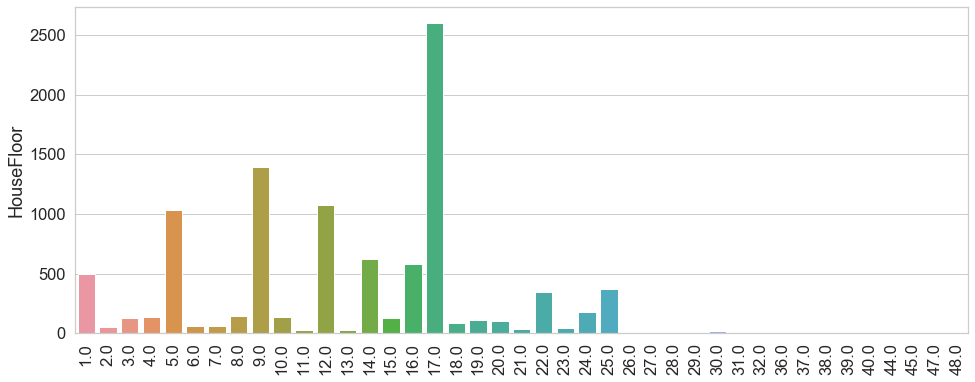

In [80]:
sns.set(style="whitegrid", font_scale=1.5)

f, ax = plt.subplots(figsize=(16, 6))
sns.barplot(y=train_df['HouseFloor'].value_counts(), x=train_df['HouseFloor'].value_counts().index,
#           order=train_df['HouseFloor'].value_counts().index
           );
ax.tick_params(axis='x', rotation=90)

In [81]:
train_df.loc[train_df['HouseFloor'] <= 5, 'HouseFloor_cat'] = 1  
train_df.loc[(train_df['HouseFloor'] > 5) & (train_df['HouseFloor'] <= 12), 'HouseFloor_cat'] = 2
train_df.loc[(train_df['HouseFloor'] > 12) & (train_df['HouseFloor'] <= 17), 'HouseFloor_cat'] = 3
train_df.loc[train_df['HouseFloor'] > 17, 'HouseFloor_cat'] = 4

test_df.loc[test_df['HouseFloor'] <= 5, 'HouseFloor_cat'] = 1  
test_df.loc[(test_df['HouseFloor'] > 5) & (test_df['HouseFloor'] <= 12), 'HouseFloor_cat'] = 2
test_df.loc[(test_df['HouseFloor'] > 12) & (test_df['HouseFloor'] <= 17), 'HouseFloor_cat'] = 3
test_df.loc[test_df['HouseFloor'] > 17, 'HouseFloor_cat'] = 4

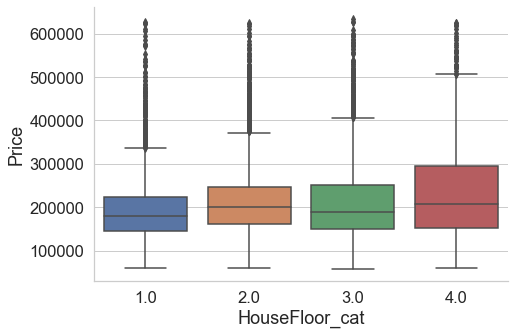

In [82]:
sns.catplot("HouseFloor_cat", "Price", kind="box", data=train_df, aspect=3/2);

In [83]:
train_df[['Floor_cat', 'HouseFloor_cat']] = train_df[['Floor_cat', 'HouseFloor_cat']].astype(int)
test_df[['Floor_cat', 'HouseFloor_cat']] = test_df[['Floor_cat', 'HouseFloor_cat']].astype(int)

## Отбор признаков

In [84]:
train_df.to_csv('train_prepared.csv')
test_df.to_csv('test_prepared.csv')

In [85]:
feature_names = train_df.columns
feature_names.tolist()

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'DistrictSize',
 'PriceOneSMeter',
 'PriceOneSMeterByDistrict',
 'RoomSquare',
 'Floor_cat',
 'HouseFloor_cat']

In [98]:
target_name = ['Price']
feature_names = [
#             'DistrictId',
             'Rooms',
             'Square',
#             'LifeSquare',
             'KitchenSquare',
             'Floor',
             'HouseFloor',
             'HouseYear',
             'Ecology_1',
#             'Ecology_2',
#             'Ecology_3',
             'Social_1',
             'Social_2',
             'Social_3',
#             'Healthcare_1',
             'Helthcare_2',
             'Shops_1',
#             'Shops_2',
#             'Price',
             'DistrictSize',
#             'PriceOneSMeter',
             'PriceOneSMeterByDistrict',
             'RoomSquare',
             'HouseFloor_cat'
                ]

In [99]:
X = train_df[feature_names]
y = train_df[target_name]

X_test = test_df[feature_names]

In [100]:
len(feature_names)

16

## Построение модели Random Forest

**Перекрестная проверка модели**

In [111]:
forest = RandomForestRegressor(max_depth=19, 
                               max_features=5, 
                               n_estimators=400,
                               random_state=42)

In [112]:
kf = KFold(n_splits=5, random_state=42, shuffle=True)

cv_score = cross_val_score(forest, X, y, scoring='r2', cv=kf)
print('R2: {:.5f}'.format(cv_score.mean()))
# R2: 0.73977 (n_splits=10)

R2: 0.74113


**Важность признаков**

In [103]:
forest.fit(X, y)
importances = forest.feature_importances_
feat_importances = pd.Series(importances, index=feature_names)
feat_importances.sort_values(ascending=True, inplace=True)

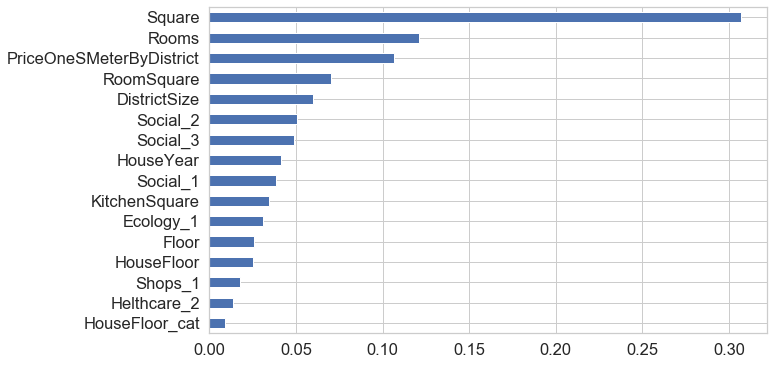

In [104]:
feat_importances.plot(kind='barh', figsize=(10, 6));

## Настройка гиперпараметров модели

In [105]:
params = {
    'n_estimators': [400],
    'max_depth': [18,19,20],
    'max_features': [5,6,7]
}

In [106]:
forest_grid = GridSearchCV(forest, params, scoring='r2', 
                  cv=KFold(n_splits=10, random_state=42, shuffle=True), 
                  n_jobs=-1)
forest_grid.fit(X, y)
print(forest_grid.best_params_)
print('R2 на train: {:.5f}'.format(forest_grid.best_score_)) # 0.74441

{'max_depth': 19, 'max_features': 5, 'n_estimators': 400}
R2 на train: 0.74468


## Построение GradientBoosting модели

In [125]:
gb_model = GradientBoostingRegressor(n_estimators=200, max_depth=5, random_state=42)
gb_model.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [126]:
kf = KFold(n_splits=5, random_state=42, shuffle=True)

cv_score = cross_val_score(gb_model, X, y, scoring='r2', cv=kf)
print('R2: {:.5f}'.format(cv_score.mean()))

R2: 0.74437


In [122]:
params = {'n_estimators':[100, 200], 
          'max_depth':[5, 7, 9]}

gs = GridSearchCV(gb_model, params, scoring='r2', 
                  cv=KFold(n_splits=10, random_state=42, shuffle=True), n_jobs=-1)
gs.fit(X, y)

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             error_score='raise-deprecating',
             estimator=GradientBoostingRegressor(alpha=0.9,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                           

In [123]:
gs.best_params_

{'max_depth': 5, 'n_estimators': 200}

In [124]:
gs.best_score_

0.7477392244456098

## Прогнозирование на тестовом датасете

1. Выполнять для тестового датасета те же этапы обработки и построения признаков
2. Не потерять и не перемешать индексы тестового датасета при построении прогнозов
3. Прогнозы должны быть для всех примеров из тестового датасета

In [127]:
gs_best = gs.best_estimator_

y_pred = gs_best.predict(X_test)

In [128]:
preds = pd.DataFrame()
preds['Id'] = X_test.index
preds['Price'] = y_pred
preds.head()

,Id,Price
0,725,"158,572.83"
1,15856,"213,842.40"
2,5480,"245,247.87"
3,15664,"361,892.83"
4,14275,"143,195.56"


In [129]:
preds.to_csv('volkovakate_predictions.csv', index=False)